# Application of Downscaling Methods using Clmate Data as an example of Mozambique International Education

## 1. Import required Python Libraries

In [57]:
import sys
import random

import xarray
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
import datetime

from CCdownscaling import correction_downscale_methods, distribution_tests, error_metrics, som_downscale, utilities

import warnings
warnings.filterwarnings("ignore")

# for reproducibility
seed = 1
random.seed(seed)

## 2. Read Observation Weather data

* I download observation weather data from Climate Data Online - Search Tool - Daily Summaries Data on NOAA

In [2]:
# read observation weather data
moz_data = pd.read_csv('./obs/Mozambique_observation_noaa.csv')
moz_data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1980-01-04,1.0,",,S",NaN,NaN,23.8,"H,,S",28.0,",,S",22.0,",,S"
1,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1980-01-07,NaN,NaN,NaN,NaN,25.4,"H,,S",31.0,",,S",NaN,NaN
2,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1980-02-08,0.0,",,S",NaN,NaN,25.4,"H,,S",32.0,",,S",NaN,NaN
3,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1980-02-10,0.0,",,S",NaN,NaN,26.8,"H,,S",34.0,",,S",22.0,",,S"
4,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1980-02-12,0.0,",,S",NaN,NaN,25.2,"H,,S",31.0,",,S",NaN,NaN


In [3]:
moz_data["NAME"].unique()

array(['MONTEPUEZ, MZ', 'CHIMOIO, MZ', 'TETE, MZ', 'CHANGALANE, MZ',
       'MOCIMBOA DA PRAIA, MZ', 'VILANKULO, MZ', 'PANDA INHAMBANE, MZ',
       'PAFURI, SF', 'LICHINGA, MZ', 'PEMBA, MZ', 'NAMPULA, MZ',
       'XAI XAI, MZ', 'INHAMBANE, MZ', 'ANGOCHE, MZ', 'LUMBO, MZ',
       'CUAMBA, MZ', 'MAPUTO, MZ', 'MAPULANGUENE MAPUTO, MZ', 'BEIRA, MZ'],
      dtype=object)

In [4]:
moz_maputo_data = moz_data[moz_data['NAME'] == 'MAPUTO, MZ']
moz_maputo_data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
113029,MZM00067341,"MAPUTO, MZ",-25.921,32.573,44.2,1980-01-01,0.0,",,S",NaN,NaN,29.7,"H,,S",39.0,",,S",20.0,",,S"
113030,MZM00067341,"MAPUTO, MZ",-25.921,32.573,44.2,1980-01-02,2.0,",,S",NaN,NaN,26.2,"H,,S",29.0,",,S",23.0,",,S"
113031,MZM00067341,"MAPUTO, MZ",-25.921,32.573,44.2,1980-01-03,0.0,",,S",NaN,NaN,29.0,"H,,S",35.0,",,S",22.0,",,S"
113032,MZM00067341,"MAPUTO, MZ",-25.921,32.573,44.2,1980-01-04,0.0,",,S",NaN,NaN,33.0,"H,,S",43.0,",,S",26.0,",,S"
113033,MZM00067341,"MAPUTO, MZ",-25.921,32.573,44.2,1980-01-05,0.0,",,S",NaN,NaN,32.3,"H,,S",NaN,NaN,26.0,",,S"


In [5]:
moz_maputo_data_df = moz_maputo_data[["DATE","PRCP","TAVG","TMAX","TMIN"]]
moz_maputo_data_df.head()

,DATE,PRCP,TAVG,TMAX,TMIN
113029,1980-01-01,0.0,29.7,39.0,20.0
113030,1980-01-02,2.0,26.2,29.0,23.0
113031,1980-01-03,0.0,29.0,35.0,22.0
113032,1980-01-04,0.0,33.0,43.0,26.0
113033,1980-01-05,0.0,32.3,NaN,26.0


In [6]:
def date_format(df):
    dt_series = []
    for date in df['DATE'].values:
        datetimeobj = datetime.datetime(int(str(date)[0:4]), int(str(date)[5:7]), int(str(date)[8:10]))
        dt_series.append(datetimeobj)
    df["DATE"] = dt_series
    return df

In [7]:
moz_maputo_data_df = date_format(moz_maputo_data_df)
moz_maputo_data_df.set_index("DATE").head()
moz_maputo_data_df.head()

,DATE,PRCP,TAVG,TMAX,TMIN
113029,1980-01-01,0.0,29.7,39.0,20.0
113030,1980-01-02,2.0,26.2,29.0,23.0
113031,1980-01-03,0.0,29.0,35.0,22.0
113032,1980-01-04,0.0,33.0,43.0,26.0
113033,1980-01-05,0.0,32.3,NaN,26.0


In [8]:
total_date_df = pd.DataFrame(
    {'DATE': pd.date_range(start='1980-01-01', end='2022-12-31', freq='1D'),
    }
)
print(len(total_date_df))
total_date_df.head()

15706


,DATE
0,1980-01-01
1,1980-01-02
2,1980-01-03
3,1980-01-04
4,1980-01-05


In [13]:
moz_maputo_data_f = pd.merge(total_date_df, moz_maputo_data_df, on="DATE", how="left")
moz_maputo_data_f = moz_maputo_data_f.set_index("DATE")[['PRCP']]
moz_maputo_data_f

,PRCP
DATE,
1980-01-01,0.0
1980-01-02,2.0
1980-01-03,0.0
1980-01-04,0.0
1980-01-05,0.0
...,...
2022-12-27,NaN
2022-12-28,NaN
2022-12-29,NaN


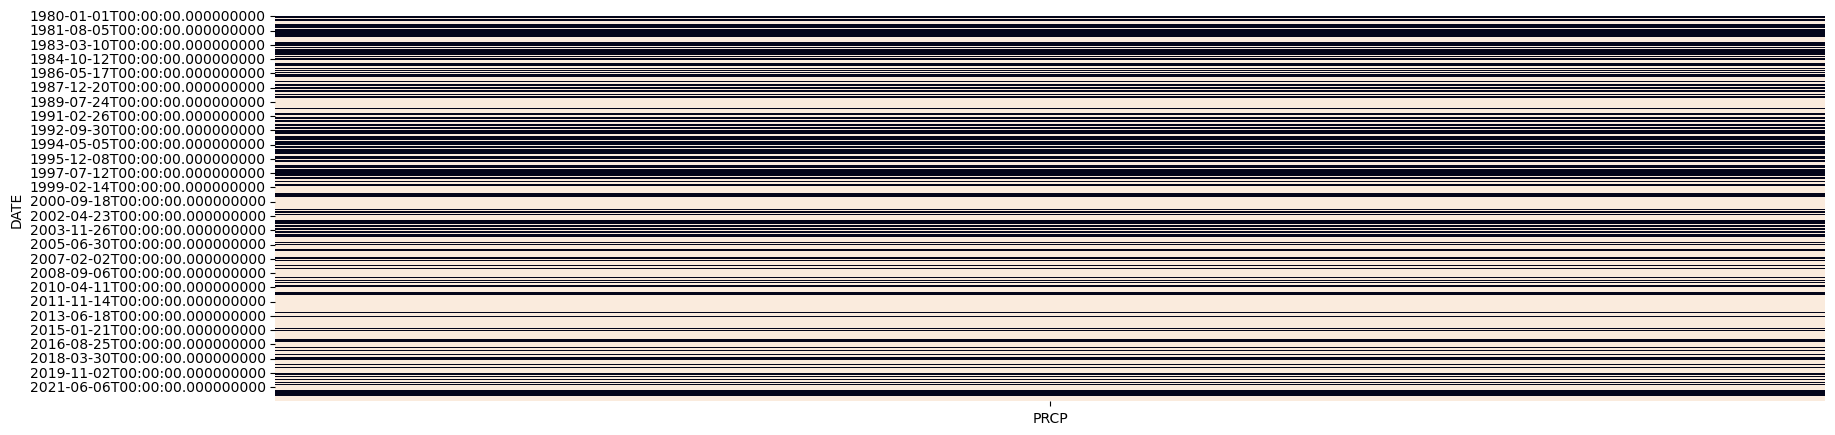

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(moz_maputo_data_f.isnull(), cbar=False)
plt.show()

In [15]:
moz_maputo_obs = moz_maputo_data_f.fillna(0)
moz_maputo_obs

,PRCP
DATE,
1980-01-01,0.0
1980-01-02,2.0
1980-01-03,0.0
1980-01-04,0.0
1980-01-05,0.0
...,...
2022-12-27,0.0
2022-12-28,0.0
2022-12-29,0.0


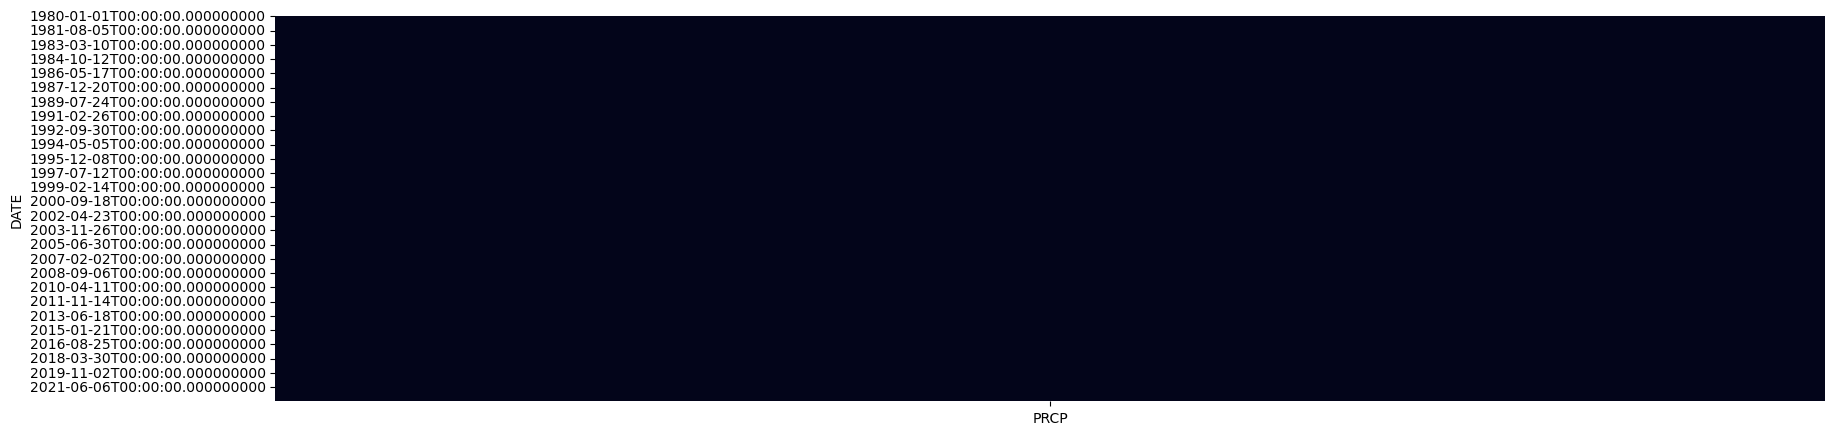

In [16]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(moz_maputo_obs.isnull(), cbar=False)
plt.show()

## 3. Read GCM historical data

In [17]:
# read five nc files
gcm_data = xarray.open_dataset('./ipcc_data/historical_data/pr_day_EC-Earth3-Veg-LR_historical_r1i1p1f1_gr_18500101-20141231_v20200217.nc')
gcm_data

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, lat: 1, lon: 1)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat        (lat) float64 -25.23
  * lon        (lon) float64 32.62
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    contact:                cmip6-data@ec-earth.org
    creation_date:          2020-02-17T13:29:51Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    branch_time_in_parent:  164359.0
    tracking_id:            hdl:21.14100/037c3f46-ad12-415a-bfaf-812c1bf9662f

### 3.1 Remove Feb-29, Feb-30 considering leap years

In [18]:
start_year = 1850
end_year = 2014
leap_years = list(range(start_year + (4 - start_year % 4), end_year + 1, 4))
leap_years.remove(leap_years[12])
no_leap_years = list(range(start_year, end_year + 1, 1))
li = no_leap_years
remove_set = {3, 5}

li = [i for i in li if i not in leap_years]
li

[1850,
 1851,
 1853,
 1854,
 1855,
 1857,
 1858,
 1859,
 1861,
 1862,
 1863,
 1865,
 1866,
 1867,
 1869,
 1870,
 1871,
 1873,
 1874,
 1875,
 1877,
 1878,
 1879,
 1881,
 1882,
 1883,
 1885,
 1886,
 1887,
 1889,
 1890,
 1891,
 1893,
 1894,
 1895,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1905,
 1906,
 1907,
 1909,
 1910,
 1911,
 1913,
 1914,
 1915,
 1917,
 1918,
 1919,
 1921,
 1922,
 1923,
 1925,
 1926,
 1927,
 1929,
 1930,
 1931,
 1933,
 1934,
 1935,
 1937,
 1938,
 1939,
 1941,
 1942,
 1943,
 1945,
 1946,
 1947,
 1949,
 1950,
 1951,
 1953,
 1954,
 1955,
 1957,
 1958,
 1959,
 1961,
 1962,
 1963,
 1965,
 1966,
 1967,
 1969,
 1970,
 1971,
 1973,
 1974,
 1975,
 1977,
 1978,
 1979,
 1981,
 1982,
 1983,
 1985,
 1986,
 1987,
 1989,
 1990,
 1991,
 1993,
 1994,
 1995,
 1997,
 1998,
 1999,
 2001,
 2002,
 2003,
 2005,
 2006,
 2007,
 2009,
 2010,
 2011,
 2013,
 2014]

In [19]:
# remove Feb-30
for a_year in no_leap_years:
    gcm_data = gcm_data.sel(time=~((gcm_data.time.dt.year == a_year) & (gcm_data.time.dt.month == 2) & (gcm_data.time.dt.day == 30)))

In [20]:
# remove Feb-29
for a_year in li:
    gcm_data = gcm_data.sel(time=~((gcm_data.time.dt.year == a_year) & (gcm_data.time.dt.month == 2) & (gcm_data.time.dt.day == 29)))

In [21]:
gcm_data

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, lat: 1, lon: 1)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat        (lat) float64 -25.23
  * lon        (lon) float64 32.62
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 5.765e-06 1.078e-05 ... 1.464e-05
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    contact:                cmip6-data@ec-earth.org
    creation_date:          2020-02-17T13:29:51Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    branch_time_in_parent:  164359.0
    tracking_id:            hdl:21.14100/037c3f46-ad12-415a-bfaf-812c1bf9662f

### 3.2 Set Station Lat and Lon

In [22]:
station_lat = -25.95528
station_lon = 32.58916
station_lat, station_lon

(-25.95528, 32.58916)

### 3.3 Change precipitation unit and extract data using analysis periods, lat and lon

In [23]:
# load GCM historical data
gcm_data['pr'] = gcm_data['pr'] * 86400
gcm_precip1 = gcm_data['pr'].sel(time=slice('1980-01-01','2014-12-31'))
gcm_precip2 = gcm_precip1.sel(lat=station_lat, lon=station_lon, method='nearest').values
gcm_precip = np.squeeze(gcm_precip2)

In [26]:
total_date_df = pd.DataFrame(
    {'DATE': pd.date_range(start='1980-01-01', end='2014-12-31', freq='1D'),
    }
)
print(len(total_date_df))
total_date_df["gcm_precip"] = gcm_precip
total_date_df

12784


,DATE,gcm_precip
0,1980-01-01,1.590729
1,1980-01-02,0.541210
2,1980-01-03,1.770020
3,1980-01-04,1.100779
4,1980-01-05,0.861168
...,...,...
12779,2014-12-27,16.443968
12780,2014-12-28,29.594898
12781,2014-12-29,21.683455
12782,2014-12-30,3.904819


## 4. Merge Station Observation and GCM historical data

In [27]:
total_data = pd.merge(total_date_df, moz_maputo_obs, on="DATE", how="left")
total_data

,DATE,gcm_precip,PRCP
0,1980-01-01,1.590729,0.0
1,1980-01-02,0.541210,2.0
2,1980-01-03,1.770020,0.0
3,1980-01-04,1.100779,0.0
4,1980-01-05,0.861168,0.0
...,...,...,...
12779,2014-12-27,16.443968,39.9
12780,2014-12-28,29.594898,14.0
12781,2014-12-29,21.683455,124.0
12782,2014-12-30,3.904819,7.1


In [28]:
print(len(total_data[total_data.isna().any(axis=1)]))
total_data[total_data.isna().any(axis=1)]

0


,DATE,gcm_precip,PRCP


In [29]:
# 결측이 없음을 확인함
col_name = list(total_data)
total_data[col_name] = total_data[col_name].interpolate(method="pad")
total_data[total_data.isna().any(axis=1)]

,DATE,gcm_precip,PRCP


In [30]:
total_data = total_data.fillna(0)
total_data

,DATE,gcm_precip,PRCP
0,1980-01-01,1.590729,0.0
1,1980-01-02,0.541210,2.0
2,1980-01-03,1.770020,0.0
3,1980-01-04,1.100779,0.0
4,1980-01-05,0.861168,0.0
...,...,...,...
12779,2014-12-27,16.443968,39.9
12780,2014-12-28,29.594898,14.0
12781,2014-12-29,21.683455,124.0
12782,2014-12-30,3.904819,7.1


## 6. Split train and test sets

In [31]:
# split train and test sets:
# train_split = int(round(input_data.shape[0]*0.8))
input_data = total_data["gcm_precip"]
hist_data = total_data["PRCP"]
train_split = int(len(total_data)*0.8)  # split out the first 24 years for the training data, last 6 years for the test set
training_data = input_data[0:train_split].values.reshape(-1, 1)
train_hist = hist_data[0:train_split].values.reshape(-1, 1)
test_data = input_data[train_split:].values.reshape(-1, 1)
test_hist = hist_data[train_split:].values.reshape(-1, 1)
#rean_precip_train = rean_precip[0:train_split]
#rean_precip_test = rean_precip[train_split:]
print(training_data.shape, test_data.shape)

(10227, 1) (2557, 1)


In [32]:
# intialize the different methods
#som = som_downscale(som_x=7, som_y=5, batch=512, alpha=0.1, epochs=50)
rf_two_part = correction_downscale_methods.two_step_random_forest()
random_forest = sklearn.ensemble.RandomForestRegressor()
qmap = correction_downscale_methods.quantile_mapping()
linear = sklearn.linear_model.LinearRegression()

## 7. Train Climate Data

In [33]:
# train
#som.fit(training_data, train_hist, seed=1)
random_forest.fit(training_data, train_hist)
rf_two_part.fit(training_data, train_hist)
linear.fit(training_data, train_hist)
qmap.fit(training_data, train_hist)

(1465, 1) (1465, 1)


array([-4.93028606e-19, -3.82779491e-19, -3.63094763e-19, ...,
       -1.36104351e+02, -2.54309487e+02, -3.46700490e+02])

## 8. Test and Visualize Climate data 

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [35]:
# generate outputs from the test data
#som_output = som.predict(test_data)
random_forest_output = random_forest.predict(test_data)
rf_two_part_output = rf_two_part.predict(test_data)
qmap_output = qmap.predict(test_data)

In [36]:
mse = mean_squared_error(test_hist, random_forest_output)
mae = mean_absolute_error(test_hist, random_forest_output)
r2 = r2_score(test_hist, random_forest_output)
mse, mae, r2

(139.31803168987642, 3.0322043095813425, -0.3851474340170904)

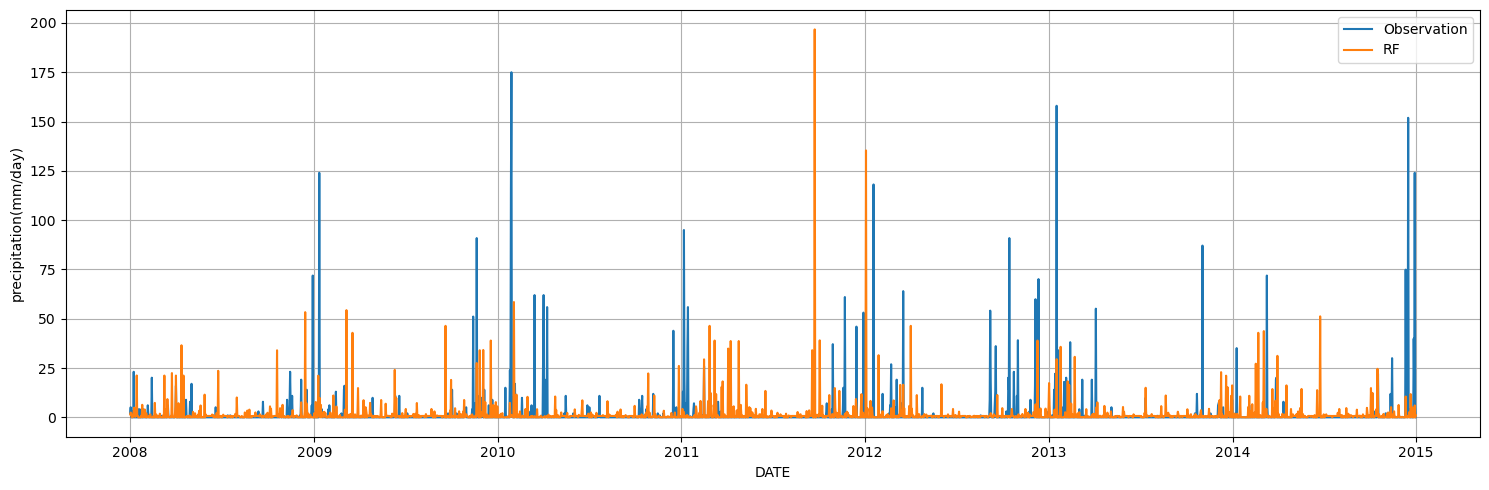

In [39]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["DATE"][train_split:].values, test_hist, total_data["DATE"][train_split:].values, random_forest_output)
ax.set_xlabel('DATE')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'RF'])
fig.tight_layout()
plt.show()

In [40]:
mse = mean_squared_error(test_hist, rf_two_part_output)
mae = mean_absolute_error(test_hist, rf_two_part_output)
r2 = r2_score(test_hist, rf_two_part_output)
mse, mae, r2

(139.60098004613747, 2.433525580953397, -0.3879606031731604)

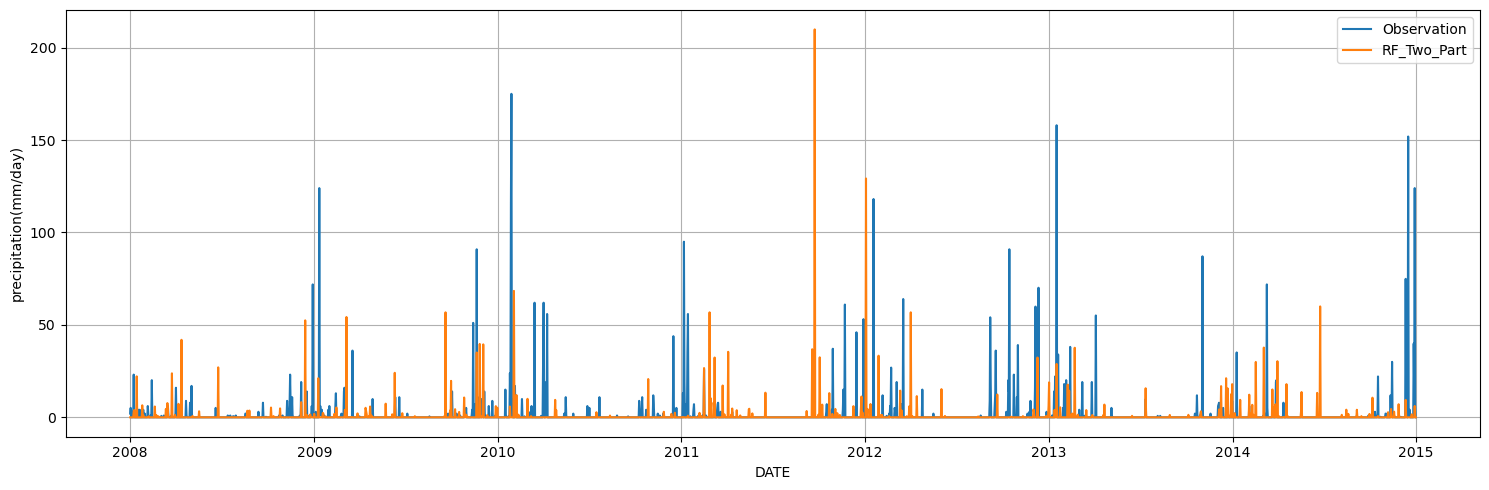

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["DATE"][train_split:].values, test_hist, total_data["DATE"][train_split:].values, rf_two_part_output)
ax.set_xlabel('DATE')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'RF_Two_Part'])
fig.tight_layout()
plt.show()

In [42]:
mse = mean_squared_error(test_hist, qmap_output)
mae = mean_absolute_error(test_hist, qmap_output)
r2 = r2_score(test_hist, qmap_output)
mse, mae, r2

(147.84465025851765, 3.016608760222932, -0.4699219868006559)

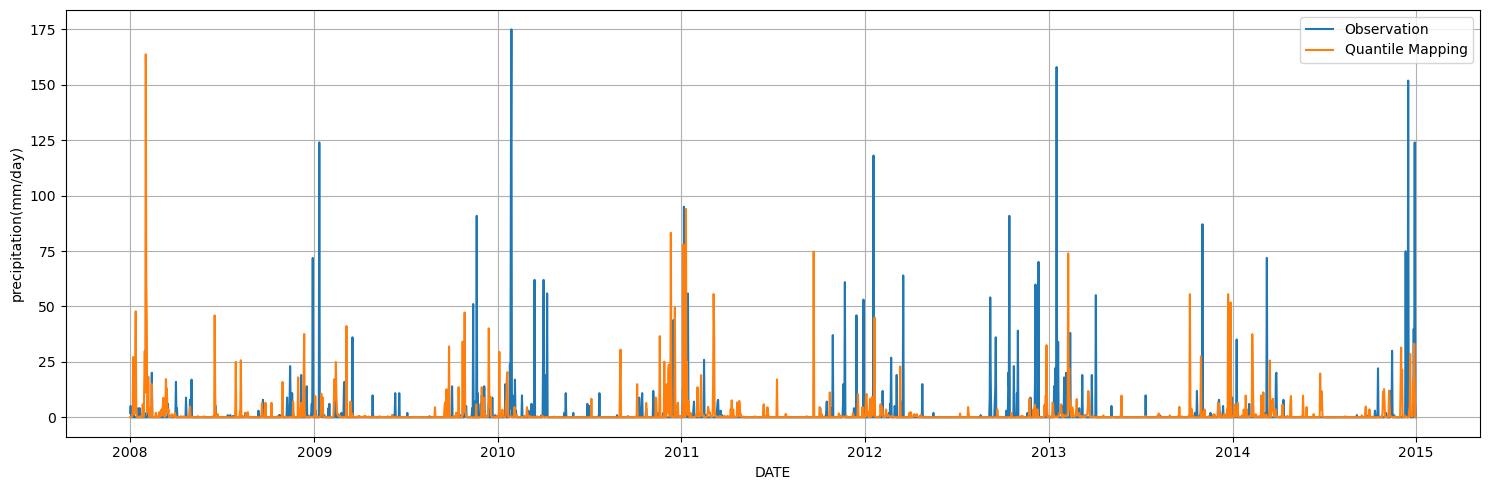

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["DATE"][train_split:].values, test_hist, total_data["DATE"][train_split:].values, qmap_output)
ax.set_xlabel('DATE')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'Quantile Mapping'])
fig.tight_layout()
plt.show()

## 9. Create Future Precipitations

In [44]:
# read five nc files
scenario_data = xarray.open_dataset('./ipcc_data/projection_data/pr_day_EC-Earth3-Veg-LR_ssp370_r1i1p1f1_gr_20220101-21001231_v20201123.nc')
scenario_data

<xarray.Dataset>
Dimensions:    (time: 28854, bnds: 2, lat: 1, lon: 1)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat        (lat) float64 -25.23
  * lon        (lon) float64 32.62
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP AerChemMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/b09f3840-378e-4f67-a245-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

### 9.1 Remove Feb-29, Feb-30 considering leap years

In [45]:
start_year = 2022
end_year = 2100
leap_years = list(range(start_year + (4 - start_year % 4), end_year + 1, 4))
leap_years.remove(leap_years[12])
no_leap_years = list(range(start_year, end_year + 1, 1))
li = no_leap_years
remove_set = {3, 5}

li = [i for i in li if i not in leap_years]
li

[2022,
 2023,
 2025,
 2026,
 2027,
 2029,
 2030,
 2031,
 2033,
 2034,
 2035,
 2037,
 2038,
 2039,
 2041,
 2042,
 2043,
 2045,
 2046,
 2047,
 2049,
 2050,
 2051,
 2053,
 2054,
 2055,
 2057,
 2058,
 2059,
 2061,
 2062,
 2063,
 2065,
 2066,
 2067,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2077,
 2078,
 2079,
 2081,
 2082,
 2083,
 2085,
 2086,
 2087,
 2089,
 2090,
 2091,
 2093,
 2094,
 2095,
 2097,
 2098,
 2099]

In [46]:
# remove Feb-30
for a_year in no_leap_years:
    scenario_data = scenario_data.sel(time=~((scenario_data.time.dt.year == a_year) & (scenario_data.time.dt.month == 2) & (scenario_data.time.dt.day == 30)))

In [47]:
# remove Feb-29
for a_year in li:
    scenario_data = scenario_data.sel(time=~((scenario_data.time.dt.year == a_year) & (scenario_data.time.dt.month == 2) & (scenario_data.time.dt.day == 29)))

In [48]:
scenario_data

<xarray.Dataset>
Dimensions:    (time: 28853, bnds: 2, lat: 1, lon: 1)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat        (lat) float64 -25.23
  * lon        (lon) float64 32.62
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2022-01-01 2022-01-02 ... 2101-01-01
    lat_bnds   (time, lat, bnds) float64 -25.79 -24.67 -25.79 ... -25.79 -24.67
    lon_bnds   (time, lon, bnds) float64 32.06 33.19 32.06 ... 33.19 32.06 33.19
    pr         (time, lat, lon) float32 8.576e-06 4.581e-06 ... 2.605e-06
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        ScenarioMIP AerChemMIP
    branch_method:                      standard
    branch_time_in_child:               60265.0
    branch_time_in_parent:              60265.0
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    title:                              EC-Earth3-Veg-LR output prepared for ...
    tracking_id:                        hdl:21.14100/b09f3840-378e-4f67-a245-...
    variable_id:                        pr
    variant_label:                      r1i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

### 3.2 Set Station Lat and Lon

In [49]:
station_lat = -25.95528
station_lon = 32.58916
station_lat, station_lon

(-25.95528, 32.58916)

### 3.3 Change precipitation unit and extract data using analysis periods, lat and lon

In [50]:
# load GCM historical data
scenario_data['pr'] = scenario_data['pr'] * 86400
scenario_data1 = scenario_data['pr'].sel(time=slice('2022-01-01','2100-12-31'))
scenario_data2 = scenario_data1.sel(lat=station_lat, lon=station_lon, method='nearest').values
scenario_precip = np.squeeze(scenario_data2)

In [51]:
total_date_df = pd.DataFrame(
    {'date': pd.date_range(start='2022-01-01', end='2100-12-30', freq='1D'),
    }
)
print(len(total_date_df))
total_date_df["scenario_precip"] = scenario_precip
total_date_df

28853


,date,scenario_precip
0,2022-01-01,0.741005
1,2022-01-02,0.395775
2,2022-01-03,0.614166
3,2022-01-04,0.274658
4,2022-01-05,0.874519
...,...,...
28848,2100-12-26,24.946211
28849,2100-12-27,1.567840
28850,2100-12-28,17.103672
28851,2100-12-29,0.005722


In [52]:
scenario_precip.reshape(-1, 1)

array([[7.41004926e-01],
       [3.95774844e-01],
       [6.14166235e-01],
       ...,
       [1.71036716e+01],
       [5.72204556e-03],
       [2.25067125e-01]])

In [53]:
# generate outputs from the test data
random_forest_output = random_forest.predict(scenario_precip.reshape(-1, 1))
rf_two_part_output = rf_two_part.predict(scenario_precip.reshape(-1, 1))
qmap_output = qmap.predict(scenario_precip.reshape(-1, 1))

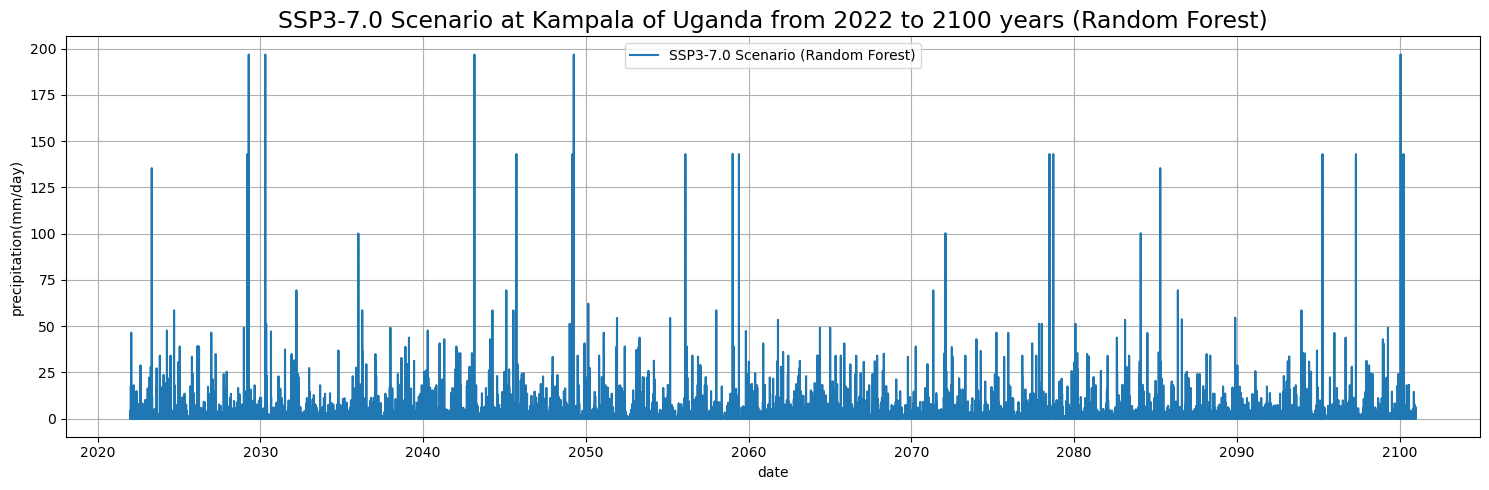

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, random_forest_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Random Forest)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Random Forest)', fontsize=17)
fig.tight_layout()
plt.show()

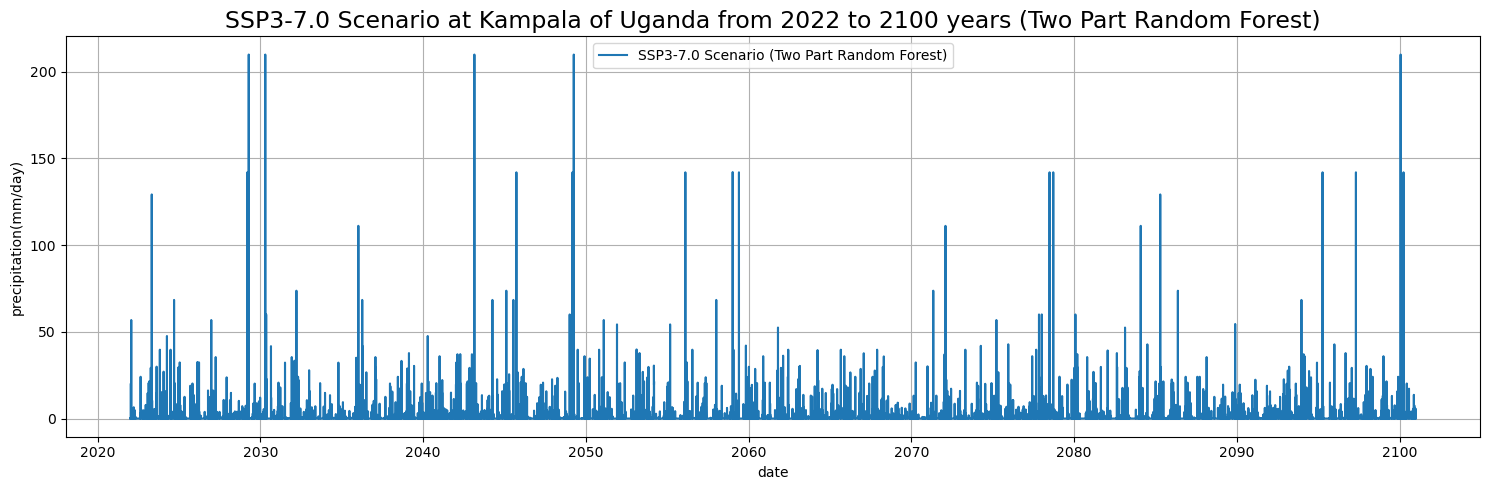

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, rf_two_part_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Two Part Random Forest)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Two Part Random Forest)', fontsize=17)
fig.tight_layout()
plt.show()

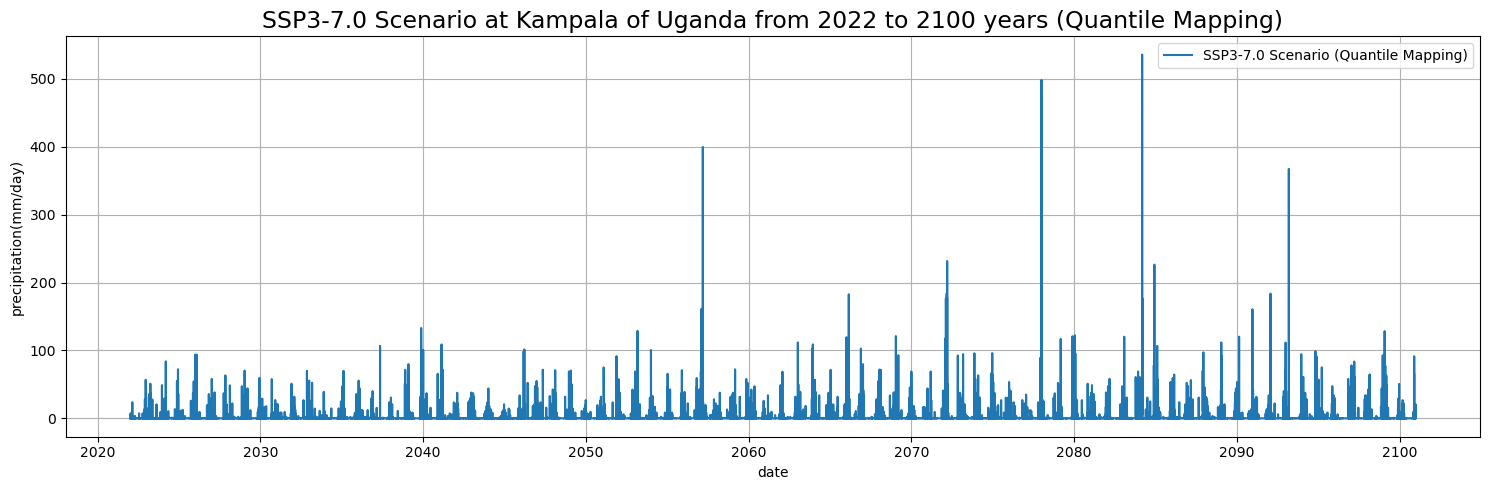

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, qmap_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Quantile Mapping)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Quantile Mapping)', fontsize=17)
fig.tight_layout()
plt.show()